In [57]:
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [59]:
from importlib import reload

reload(piano)
# reload(sampling_utils)
# reload(sampling)

<module 'config.eval.piano_hollow' from '../config/eval/piano_hollow.py'>

In [60]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

import config.eval.piano_hollow as piano
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = piano.get_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
# device = torch.device(eval_cfg.device)
device = torch.device("cuda")

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data
test_dataset = np.load(eval_cfg.sampler.test_dataset)
condition_dim = eval_cfg.sampler.condition_dim
descramble_key = np.loadtxt(eval_cfg.pianoroll_dataset_path + '/descramble_key.txt')
# The mask stays the same
descramble_key = np.concatenate([descramble_key, np.array([descramble_key.shape[0]])], axis=0)

def descramble(samples):
    return descramble_key[samples.flatten()].reshape(*samples.shape)

descrambled_test_dataset = descramble(test_dataset)

  0%|          | 0/224 [10:10<?, ?it/s]


KeyError: 'AbsorbingHollowSequenceTransformerFlash'

In [61]:
eval_cfg

checkpoint_path: /home/groups/swl1/yixiuz/torch_fid/experiments/piano/2024-05-14/00-36-56_piano_absorbing_hollow/checkpoints/ckpt_0000999999.pt
data:
  S: 130
  batch_size: 64
  name: LakhPianoroll
  path: /home/groups/swl1/yixiuz/torch_fid/downloads/pianoroll_dataset/train.npy
  shape:
  - 256
  shuffle: true
device: cpu
eval_name: piano
pianoroll_dataset_path: /home/groups/swl1/yixiuz/torch_fid/downloads/pianoroll_dataset
sampler:
  balancing_function: mpf
  condition_dim: 32
  corrector_entry_time: 0.9
  corrector_step_size_multiplier: 0.1
  eps_ratio: 1.0e-09
  initial_dist: absorbing
  min_t: 0.01
  name: ConditionalPCTauLeapingAbsorbingInformed
  num_corrector_steps: 2
  num_steps: 1000
  reject_multiple_jumps: true
  test_dataset: /home/groups/swl1/yixiuz/torch_fid/downloads/pianoroll_dataset/test.npy
train_config_overrides:
- - - device
  - cpu
- - - data
    - path
  - /home/groups/swl1/yixiuz/torch_fid/downloads/pianoroll_dataset/train.npy
- - - distributed
  - false
train_co

In [6]:
from lib.sampling.sampling import compute_backward, get_initial_samples

In [48]:
from tqdm import trange, tqdm

class ConditionalGillespies():
    def __init__(self, cfg):
        self.cfg =cfg

    def sample(self, model, N, num_intermediates, conditioner, updates_per_eval=1):
        assert conditioner.shape[0] == N
        
        condition_dim = self.cfg.sampler.condition_dim
        total_D = np.prod(self.cfg.data.shape)
        D = total_D - condition_dim
        
        S = self.cfg.data.S
        scfg = self.cfg.sampler
        num_steps = scfg.num_steps
        min_t = scfg.min_t
        eps_ratio = scfg.eps_ratio
        initial_dist = scfg.initial_dist
        if initial_dist == 'gaussian':
            initial_dist_std  = model.Q_sigma
        else:
            initial_dist_std = None
        device = model.device
        # Corrector stuff
        num_corrector_steps = scfg.num_corrector_steps
        corrector_step_size_multiplier = scfg.corrector_step_size_multiplier
        corrector_entry_time = scfg.corrector_entry_time
        if scfg.balancing_function == "barker":
            balancing_function = lambda score: score / (1 + score) 
        elif scfg.balancing_function == "mpf":
            balancing_function = lambda score: torch.sqrt(score)
        elif scfg.balancing_function == "birthdeath":
            balancing_function = None
        else:
            print("Balancing function not found: " + scfg.balancing_function)
            return

        # Now the batch is not syncronized anymore
        ts = 1.0 * torch.ones((N,), device=device)
        update_mask = ts > min_t
        num_updates = 0
        
        with torch.no_grad():
            x = get_initial_samples(N, D, device, S, initial_dist,
                initial_dist_std)

            x_hist = []
            x0_hist = []

            pbar = tqdm(total=D)
            while num_updates < D:

                # Compute backward transition rate
                qt0 = model.transition(ts) # (N, S, S)
                rate = model.rate(ts) # (N, S, S)

                model_input = torch.concat((conditioner, x), dim=1)
                p0t = F.softmax(model(model_input, ts), dim=2) # (N, D, S)
                p0t = p0t[:, condition_dim:, :]

                Rf, RfT, Rb, x_0max, scores = compute_backward(qt0, rate, p0t, x)
                # Rb: (N, D, S)
                Rb[torch.arange(N, device=device).repeat_interleave(D),
                   torch.arange(D, device=device).repeat(N),
                   x.long().flatten()] = eps_ratio
            
                # Compute total rate (N, D)
                Rb_sum = torch.sum(Rb, axis=2)
                # Sample a holding time (N, D)
                taus = torch.distributions.Exponential(Rb_sum).sample()
                # Find the position of the shortest holding time for each dimension (N,)
                ids_sorted = torch.argsort(taus, axis=1)
                dts = torch.zeros((N,), device=device)
                
                for update in range(updates_per_eval):
                    # Make one round of updates
                    ids = ids_sorted[:, update]
                    # (N,)
                    dts = taus[torch.arange(N, device=device), ids] - dts

                    # Rates given the dimensions of transition (N, S)
                    rates_single = Rb[torch.arange(N, device=device),ids]
                    # Total rate given the dimensions of transition (N, 1)
                    rates_sum_single = torch.unsqueeze(Rb_sum[torch.arange(N, device=device),ids], 1)
                    # The targets of transition (N,)
                    updates = torch.multinomial(rates_single / rates_sum_single, 1)[:,0]
                    # Update ts
                    update_mask = update_mask & ((ts - dts * update_mask) > min_t)
                    ts -= dts * update_mask
                    # Update x
                    original = x[torch.arange(N, device=device), ids]
                    x[torch.arange(N, device=device), ids] = updates * update_mask + original * (~update_mask)
                    num_updates += 1
                    pbar.update(1)
                    
                # Corrector time
                def get_rates(in_x, in_t):
                    qt0 = model.transition(in_t) # (N, S, S)
                    rate = model.rate(in_t) # (N, S, S)

                    p0t = F.softmax(model(in_x, in_t), dim=2) # (N, D, S)

                    denom_x = torch.ones_like(in_x) * (S-1)

                    forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores = compute_backward(qt0, rate, p0t, in_x, denom_x=denom_x, eps=eps_ratio)
                    
                    mask_positions = in_x == (S-1)
                    nonmask_positions = ~mask_positions

                    backward_score_to_curr = scores[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ].view(N,D)
                    forward_score_from_curr = 1 / (backward_score_to_curr * nonmask_positions + mask_positions)
                    forward_score_from_curr *= nonmask_positions

                    scores = scores * mask_positions.unsqueeze(2)
                    scores[:,:,S-1] = forward_score_from_curr
                    
                    forward_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    reverse_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    
#                     assert(not scores.isnan().any())
#                     assert(not scores.isinf().any())
                    
                    return forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores
                    
                def take_poisson_step(in_x, in_reverse_rates, in_h):
                    diffs = torch.arange(S, device=device).view(1,1,S) - in_x.view(N,D,1)
                    poisson_dist = torch.distributions.poisson.Poisson(in_reverse_rates * in_h)
                    jump_nums = poisson_dist.sample()
                    adj_diffs = jump_nums * diffs
                    overall_jump = torch.sum(adj_diffs, dim=2)
                    unclip_x_new = in_x + overall_jump
                    x_new = torch.clamp(unclip_x_new, min=0, max=S-1)

                    return x_new

                if num_updates >= (1-corrector_entry_time) * D:
                    
                    h = 1/D
                    
                    for cstep in range(num_corrector_steps):
                        forward_rates, transpose_forward_rates, reverse_rates, _, scores = get_rates(x, ts) # ts-h?
                        if balancing_function is None:
                            # We're using the default corrector
                            # which corresponds to birth-death Stein operator
                            corrector_rate = transpose_forward_rates + reverse_rates
                        else:
                            # We removed the one half here because it makes more sense for the absorbing
                            corrector_rate = (transpose_forward_rates + forward_rates) * balancing_function(scores)
                        # Only update dimensions with 
                        corrector_rate *= update_mask.unsqueeze(1).unsqueeze(1)
                            
                        corrector_rate[
                            torch.arange(N, device=device).repeat_interleave(D),
                            torch.arange(D, device=device).repeat(N),
                            x.long().flatten()
                        ] = eps_ratio
                        
                        x = take_poisson_step(x, corrector_rate, 
                            corrector_step_size_multiplier * h)
                
                
            model_input = torch.concat((conditioner, x), dim=1)
            p_0gt = F.softmax(model(model_input, min_t * torch.ones((N,), device=device)), dim=2) # (N, D, S)
            p_0gt = p_0gt[:, condition_dim:, :]
            
            x_0max = torch.max(p_0gt, dim=2)[1]

            mask_positions = x == (S-1)
            nonmask_positions = ~mask_positions
            samples = nonmask_positions * x + mask_positions * x_0max
            
            output = torch.concat((conditioner, samples), dim=1)
            
            return output.detach().cpu().numpy().astype(int), ts.cpu().numpy()

In [49]:
def get_dist(seq):
    S = 129
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return np.sum(one_hot, axis=0) / L

def get_mask(seq):
    S = 129
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return 1 - np.prod(1 - one_hot, axis=0)

def hellinger(seq1, seq2):
    d1, d2 = get_dist(seq1), get_dist(seq2)
    return np.sqrt(.5 * np.sum((d1 ** .5 - d2 ** .5) ** 2))

def outliers(ref, sample):
    ref_mask = get_mask(ref)
    sample_dist = get_dist(sample)
    return np.sum((1 - ref_mask) * sample_dist)

In [50]:
# Sample with PC-multi-Gillespie's and evaluate
num_samples = 5
test_data_idx = 2
conditioner = torch.from_numpy(test_dataset[test_data_idx, 0:condition_dim]).to(device).view(1, condition_dim)
conditioner = conditioner.repeat(num_samples, 1)

# play around with the sampler by overriding some configs
eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.0
eval_cfg.sampler.corrector_step_size_multiplier = .1
eval_cfg.sampler.balancing_function = "mpf"

tqdm._instances.clear()
sampler = ConditionalGillespies(eval_cfg)
samples, ts = sampler.sample(model, num_samples, 100, conditioner, )
samples = descramble(samples)

 89%|████████▉ | 199/224 [00:02<00:00, 96.70it/s]

KeyboardInterrupt: 

In [27]:
# -------------- Sample the model ------------------
num_samples = 5
test_data_idx = 2
conditioner = torch.from_numpy(test_dataset[test_data_idx, 0:condition_dim]).to(device).view(1, condition_dim)
conditioner = conditioner.repeat(num_samples, 1)

# play around with the sampler by overriding some configs
# eval_cfg.sampler.balancing_function = "birthdeath"
# eval_cfg.sampler.corrector_step_size_multiplier = 1.

# sampler = sampling_utils.get_sampler(eval_cfg)
# sampler = ConditionalTauLeaping(eval_cfg)
sampler = ConditionalGillespies(eval_cfg)
samples, ts = sampler.sample(model, num_samples, 100, conditioner)
samples = descramble(samples)

100%|██████████| 224/224 [00:01<00:00, 203.61it/s]


In [12]:
samples.shape

(5, 256)

In [ ]:
samples, hist = sampler.sample(model, num_samples, 100, conditioner)
x_hist, x0_hist = hist["x"], hist["x0"]
samples, x_hist, x0_hist = descramble(samples), descramble(x_hist), descramble(x0_hist)

In [169]:
sampler

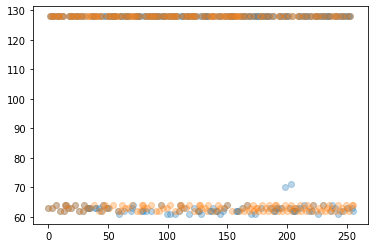

In [23]:
idx = 0
plt.scatter(np.arange(256), samples[2, :], alpha=0.3)
# plt.scatter(np.arange(256), samples[1, :], alpha=0.3)
# plt.scatter(np.arange(256), samples[2, :], alpha=0.3)
plt.scatter(np.arange(256), descrambled_test_dataset[test_data_idx, :], alpha=0.3)
plt.show()

In [14]:
t = 99
plt.scatter(np.arange(224), x_hist[t, 0], alpha=0.3)
plt.scatter(np.arange(224), x_hist[t, 1], alpha=0.3)
plt.scatter(np.arange(224), x_hist[t, 2], alpha=0.3)

NameError: name 'x_hist' is not defined

In [21]:
print(hellinger(samples[4, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:]))
print(outliers(samples[4, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:]))

0.23842151167343786
0.0


# Sample one sequence for each test data

In [46]:
device

device(type='cuda')

In [64]:
tqdm._instances.clear()
batch_size = 100

# eval_cfg.sampler.name = "ConditionalPCTauLeapingAbsorbingInformed"
# eval_cfg.sampler.balancing_function = "birthdeath"
# eval_cfg.sampler.num_steps = 500
# eval_cfg.sampler.corrector_step_size_multiplier = 0.5
eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = .2
eval_cfg.sampler.balancing_function = "barker"

# sampler = sampling_utils.get_sampler(eval_cfg)
sampler = ConditionalGillespies(eval_cfg)
test_size = test_dataset.shape[0]
h_dists = []
outlier_proportions = []
for start in range(0, test_size, batch_size):
    print(start)
    end = min(start + batch_size, test_size)
    size = end - start
    
    conditioner = torch.from_numpy(test_dataset[start:end, :condition_dim]).to(device)
    samples, _ = sampler.sample(model, size, 1, conditioner, updates_per_eval=2)
    samples = descramble(samples)

    for i in range(size):
        h = hellinger(descrambled_test_dataset[start+i, :], samples[i, :])
        r = outliers(descrambled_test_dataset[start+i, :], samples[i, :])
        h_dists.append(h)
        outlier_proportions.append(r)
        
    print("batch:", np.mean(h_dists), np.mean(outlier_proportions))
        
print(eval_cfg.sampler.name)
print("Hellinger distance", np.mean(h_dists))
print("Proportion of outliers", np.mean(outlier_proportions))

0


100%|██████████| 224/224 [00:07<00:00, 30.09it/s]


batch: 0.3707175398062234 0.11546875
100


100%|██████████| 224/224 [00:07<00:00, 30.10it/s]


batch: 0.3711175906218024 0.11662109375
200


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.37023999723028744 0.11446614583333334
300


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3742979789320714 0.119150390625
400


100%|██████████| 224/224 [00:07<00:00, 30.08it/s]


batch: 0.3738329625602685 0.1185546875
500


100%|██████████| 224/224 [00:07<00:00, 30.11it/s]


batch: 0.3754565989831902 0.12227213541666666
600


100%|██████████| 224/224 [00:07<00:00, 30.15it/s]


batch: 0.37441568642786877 0.12208705357142857
700


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.37409939580473744 0.122900390625
800


100%|██████████| 224/224 [00:07<00:00, 30.05it/s]


batch: 0.37179775346367844 0.11940538194444444
900


100%|██████████| 224/224 [00:05<00:00, 39.05it/s]

batch: 0.3748716860979322 0.12049556783144913
ConditionalPCTauLeapingAbsorbingInformed
Hellinger distance 0.3748716860979322
Proportion of outliers 0.12049556783144913


In [66]:
batch_size = 100

updates_per_eval = 2

eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = .2
eval_cfg.sampler.balancing_function = "barker"

# eval_cfg.sampler.num_corrector_steps = 1
# eval_cfg.sampler.corrector_entry_time = 0.9
# eval_cfg.sampler.corrector_step_size_multiplier = .1
# eval_cfg.sampler.balancing_function = "birthdeath"

sampler = ConditionalGillespies(eval_cfg)
test_size = test_dataset.shape[0]

all_h_dists = []
all_outlier_proportions = []

num_repeats = 5

tqdm._instances.clear()

for _ in range(num_repeats):
    h_dists = []
    outlier_proportions = []
    for start in range(0, test_size, batch_size):
        print(start)
        end = min(start + batch_size, test_size)
        size = end - start
        
        conditioner = torch.from_numpy(test_dataset[start:end, :condition_dim]).to(device)
        samples, _ = sampler.sample(model, size, 1, conditioner, 
                                    updates_per_eval=updates_per_eval)
        samples = descramble(samples)
        for i in range(size):
            h = hellinger(descrambled_test_dataset[start+i, :], samples[i, :])
            r = outliers(descrambled_test_dataset[start+i, :], samples[i, :])
            h_dists.append(h)
            outlier_proportions.append(r)
        print("batch:", np.mean(h_dists), np.mean(outlier_proportions))
            
    print("Hellinger distance", np.mean(h_dists))
    print("Proportion of outliers", np.mean(outlier_proportions))
    all_h_dists.append(np.mean(h_dists))
    all_outlier_proportions.append(np.mean(outlier_proportions))

print("------------------------------")
print("Result summary over {} runs:".format(num_repeats))
print("Hellinger distance: {}pm{}".format(np.mean(all_h_dists), np.std(all_h_dists)))
print("Proportion of outliers: {}pm{}".format(np.mean(all_outlier_proportions), 
                                              np.std(all_outlier_proportions)))

0


100%|██████████| 224/224 [00:07<00:00, 30.09it/s]


batch: 0.36839183507166096 0.11203125
100


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.36749378018312556 0.11287109375
200


100%|██████████| 224/224 [00:07<00:00, 30.15it/s]


batch: 0.3673050709870709 0.1133203125
300


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.3720713136406303 0.118095703125
400


100%|██████████| 224/224 [00:07<00:00, 30.08it/s]


batch: 0.3722532665894587 0.1181328125
500


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.37355208874377077 0.12198567708333333
600


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.3737981490824307 0.12232700892857143
700


100%|██████████| 224/224 [00:07<00:00, 30.15it/s]


batch: 0.3740336213325731 0.1241015625
800


100%|██████████| 224/224 [00:07<00:00, 30.08it/s]


batch: 0.3725635302528838 0.12112413194444445
900


100%|██████████| 224/224 [00:05<00:00, 39.10it/s]


batch: 0.37605804322262487 0.12308099948612539
Hellinger distance 0.37605804322262487
Proportion of outliers 0.12308099948612539
0


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.35954674111224155 0.1055859375
100


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3671184555040304 0.1142578125
200


100%|██████████| 224/224 [00:07<00:00, 29.97it/s]


batch: 0.36809687333108126 0.11403645833333333
300


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.37452054291330056 0.1191015625
400


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3744757099398966 0.1186875
500


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.3749249620680407 0.12125651041666667
600


100%|██████████| 224/224 [00:07<00:00, 30.07it/s]


batch: 0.37413589179613993 0.12076450892857143
700


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.37401155269339176 0.1227880859375
800


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3720914170537288 0.12008246527777777
900


100%|██████████| 224/224 [00:05<00:00, 39.07it/s]


batch: 0.375651326948952 0.12185251798561152
Hellinger distance 0.375651326948952
Proportion of outliers 0.12185251798561152
0


100%|██████████| 224/224 [00:07<00:00, 30.09it/s]


batch: 0.37100265103153957 0.1141796875
100


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.37344351121878105 0.11763671875
200


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.37179914898344485 0.11608072916666666
300


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.375513059533872 0.1205859375
400


100%|██████████| 224/224 [00:07<00:00, 30.09it/s]


batch: 0.3747844875355479 0.1207265625
500


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.37578759601824235 0.12329427083333333
600


100%|██████████| 224/224 [00:07<00:00, 30.11it/s]


batch: 0.37522180158347657 0.123046875
700


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.3756784259029527 0.124814453125
800


100%|██████████| 224/224 [00:07<00:00, 30.04it/s]


batch: 0.3737462978704444 0.12170572916666667
900


100%|██████████| 224/224 [00:05<00:00, 38.79it/s]


batch: 0.3774043236554384 0.1231372045220966
Hellinger distance 0.3774043236554384
Proportion of outliers 0.1231372045220966
0


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3644869728667571 0.111328125
100


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.36819564219621215 0.1165625
200


100%|██████████| 224/224 [00:07<00:00, 30.11it/s]


batch: 0.36997567716151175 0.11498697916666667
300


100%|██████████| 224/224 [00:07<00:00, 30.08it/s]


batch: 0.3753191952138144 0.120185546875
400


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.37564328386567053 0.120375
500


100%|██████████| 224/224 [00:07<00:00, 30.16it/s]


batch: 0.3771159453266117 0.12282552083333333
600


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.3753122972826001 0.12182477678571428
700


100%|██████████| 224/224 [00:07<00:00, 30.06it/s]


batch: 0.3750790201007436 0.122939453125
800


100%|██████████| 224/224 [00:07<00:00, 30.15it/s]


batch: 0.3730420239210404 0.11993923611111111
900


100%|██████████| 224/224 [00:05<00:00, 39.00it/s]


batch: 0.3759250593922216 0.12070031474820143
Hellinger distance 0.3759250593922216
Proportion of outliers 0.12070031474820143
0


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3711468291748934 0.1092578125
100


100%|██████████| 224/224 [00:07<00:00, 30.08it/s]


batch: 0.3726021390753276 0.11453125
200


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.37233675353546547 0.11381510416666667
300


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.3778293168057957 0.119873046875
400


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.37676788155380947 0.1189375
500


100%|██████████| 224/224 [00:07<00:00, 29.88it/s]


batch: 0.3770745066636248 0.12181640625
600


100%|██████████| 224/224 [00:07<00:00, 30.13it/s]


batch: 0.377267634630964 0.12247209821428572
700


100%|██████████| 224/224 [00:07<00:00, 30.14it/s]


batch: 0.37698233335859904 0.124443359375
800


100%|██████████| 224/224 [00:07<00:00, 30.12it/s]


batch: 0.3754196597298964 0.12149305555555556
900


100%|██████████| 224/224 [00:05<00:00, 39.01it/s]

batch: 0.3781195802568118 0.12193281089414183
Hellinger distance 0.3781195802568118
Proportion of outliers 0.12193281089414183
------------------------------
Result summary over 5 runs:
Hellinger distance: 0.37663166669520975pm0.0009591964691363689
Proportion of outliers: 0.12214076952723536pm0.0009031235562586983


In [ ]:
# Reg transformer, 3Gillespies 1ForwardBackward
# Result summary over 5 runs:
# Hellinger distance: 0.3757996870517339pm0.0014687256325569174
# Proportion of outliers: 0.12672308581706065pm0.0009465965242336641

In [ ]:
# Reg transformer, 1Gillespies
# Result summary over 5 runs:
# Hellinger distance: 0.3737476854935375pm0.00039314107832395627
# Proportion of outliers: 0.12352903391572456pm0.0010288232129788825

In [ ]:
# HollowTransformer, 3Gillespies1MPF
# Result summary over 5 runs:
# Hellinger distance: 0.374410925623968pm0.0006068406145371651
# Proportion of outliers: 0.10731388103802672pm0.001071086333231973

In [ ]:
# HollowTransformer, 2Gillespies1Barker(.2 rate)
# Result summary over 5 runs:
# Hellinger distance: 0.37663166669520975pm0.0009591964691363689
# Proportion of outliers: 0.12214076952723536pm0.0009031235562586983

In [ ]:
# HollowTransformer, 1Gillespies
# Result summary over 5 runs:
# Hellinger distance: 0.37623923435865125pm0.0016456965783516663
# Proportion of outliers: 0.12239770683453237pm0.001163738725492646

In [ ]:
# HollowTransformer (deep), 2Gillespies1MPF(.05rate)
# Result summary over 5 runs:
# Hellinger distance: 0.3767222809039338pm0.0004504722377853942
# Proportion of outliers: 0.10441691289825283pm0.0008855656271487037

In [ ]:
# HollowTransformer (deep), 3Gillespies1MPF
# Result summary over 5 runs:
# Hellinger distance: 0.37741502807366767pm0.0010161391671844433
# Proportion of outliers: 0.10295959660842754pm0.0010606355871867193

In [ ]:
# HollowTransformer (deep), 1Gillespies
# Result summary over 5 runs:
# Hellinger distance: 0.37566751329488485pm0.0006240929477967039
# Proportion of outliers: 0.12277267471736897pm0.0007224193533914502

In [ ]:
# Hollow architecture
# 0.3780593881848551
# 0.12651352132579652